# Importing modules, preprocessing


In [ ]:
#Importing the required modules, the ones I remember
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [ ]:
#Loading the data, preprocessing
from google.colab import files
uploaded = files.upload()

Saving AustriaNew.csv to AustriaNew.csv


In [ ]:
import io
dataRequired = pd.read_csv(io.BytesIO(uploaded['AustriaNew.csv']))
dataRequired.head()

,Unnamed: 0,index,AT_load_actual_entsoe_power_statistics,AT_load_actual_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,AT_windspeed_10m,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal
0,0,87656,7035.0,6343.0,36.0,2.0,109.0,3.27,-4.179,1.5614,25.9639
1,1,87657,7394.0,6882.0,41.0,10.0,146.0,3.23,-2.807,7.5467,75.0443
2,2,87658,7770.0,6963.0,45.0,21.0,146.0,3.22,-1.315,17.2073,116.9171
3,3,87659,7820.0,7110.0,50.0,32.0,158.0,3.22,-0.051,35.4289,146.8923
4,4,87660,7694.0,7136.0,51.0,37.0,187.0,3.00,0.791,58.5238,151.4721


In [ ]:
dataRequired.shape

(17488, 11)

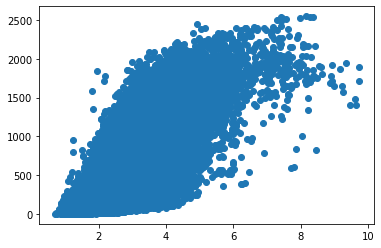

In [ ]:
#Plotting and visualising the time series relation
plt.scatter(dataRequired['AT_windspeed_10m'],dataRequired['AT_wind_onshore_generation_actual'])

In [ ]:
#Clearly, the characteristics resemble the expected characteristics, but the data had quite a bit of deviation about the standard curve.
#It can be clearly attributed to variations in density of the air density, due to radiation changes throughout the year.

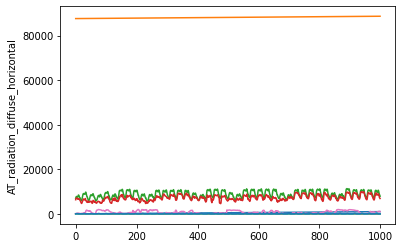

In [ ]:
#Plotting the time series
for i in dataRequired:
  plt.ylabel(i)
  plt.plot(dataRequired[i][:1000])

In [ ]:
# Certain periodic trends are found in the data, also, the series appear sufficiently correlated with one another, we thus use an LSTM for training the model

In [ ]:
#Converting the time series analysis problem into a supervised learning problem
def seriesToSupervised(data, lookBack = 60, predCols = 1):
  temp = data.copy()
  temp['id'] = range(1, len(temp)+1)
  temp = temp.iloc[: -lookBack, :]
  temp.set_index('id', inplace = True)
  predVal = data.copy()
  predVal = predVal.iloc[lookBack:, predCols]
  predVal.columns = ['Pred']
  predVal = pd.DataFrame(predVal)
  predVal['id'] = range(1, len(predVal)+1)
  predVal.set_index('id', inplace = True)
  finalDf = pd.concat([temp, predVal], axis = 1)
  return finalDf

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Solar energy output forecasting



In [ ]:
#Selecting the feature variables and target variables for a Multivariate LSTM
dataPredSolarOutput=dataRequired[['AT_solar_generation_actual', 'AT_windspeed_10m', 'AT_temperature', 'AT_radiation_direct_horizontal', 'AT_radiation_diffuse_horizontal']]
dataPredSolarOutput['pred'] = dataPredSolarOutput['AT_solar_generation_actual'].shift(-1)
dataPredSolarOutput = dataPredSolarOutput.dropna()
dataPredSolarOutput.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AT_solar_generation_actual,AT_windspeed_10m,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,pred
0,2.0,3.27,-4.179,1.5614,25.9639,10.0
1,10.0,3.23,-2.807,7.5467,75.0443,21.0
2,21.0,3.22,-1.315,17.2073,116.9171,32.0
3,32.0,3.22,-0.051,35.4289,146.8923,37.0
4,37.0,3.00,0.791,58.5238,151.4721,35.0


In [ ]:
scalerOne = MinMaxScaler(feature_range=(0,1))
solarScaled = scalerOne.fit_transform(dataPredSolarOutput.values)
solarScaled = pd.DataFrame(solarScaled)

In [ ]:
solarScaled.head()

,0,1,2,3,4,5
0,0.003279,0.285083,0.178747,0.001814,0.064377,0.016393
1,0.016393,0.280663,0.209402,0.008767,0.186070,0.034426
2,0.034426,0.279558,0.242738,0.019991,0.289892,0.052459
3,0.052459,0.279558,0.270980,0.041160,0.364214,0.060656
4,0.060656,0.255249,0.289794,0.067990,0.375570,0.057377


In [ ]:
arrDfSolar = seriesToSupervised(solarScaled, 3, 0)
arrDfSolar.fillna(0, inplace = True)
arrDfSolar.head()

,0,1,2,3,4,5,0
id,,,,,,,
1,0.003279,0.285083,0.178747,0.001814,0.064377,0.016393,0.052459
2,0.016393,0.280663,0.209402,0.008767,0.186070,0.034426,0.060656
3,0.034426,0.279558,0.242738,0.019991,0.289892,0.052459,0.057377
4,0.052459,0.279558,0.270980,0.041160,0.364214,0.060656,0.044262
5,0.060656,0.255249,0.289794,0.067990,0.375570,0.057377,0.022951


In [ ]:
# splitting and converting the data to right shape, around 80:20 ratio would be good for validation
values = arrDfSolar.values
trainSample = int(len(dataPredSolarOutput)*0.8)
train = values[: trainSample, :]
test = values[trainSample:, :]
XTrain, yTrain = train[:, :-1], train[:, -1]
XTest, yTest = test[:,:-1], test[:, -1]
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 6), (13989,), (3495, 6), (3495,))

In [ ]:
# We need a 3D data as (sample size, look back steps, input features)
XTrain = XTrain.reshape((XTrain.shape[0], 1, XTrain.shape[1]))
XTest = XTest.reshape((XTest.shape[0], 1, XTest.shape[1]))
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 1, 6), (13989,), (3495, 1, 6), (3495,))

In [ ]:
model = Sequential()
model.add(LSTM(75, return_sequences = True, input_shape = (XTrain.shape[1], XTrain.shape[2])))
model.add(LSTM(units = 50, return_sequences=True))
model.add(LSTM(units = 30))
model.add(Dense(units = 1))
model.compile(loss = 'mae', optimizer = 'adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 75)             24600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             25200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 59,551
Trainable params: 59,551
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(XTrain, yTrain, epochs= 50, batch_size=32, validation_split = 0.2, shuffle = False)

Train on 11191 samples, validate on 2798 samples
Epoch 1/50
11191/11191 [==============================] - 3s 299us/step - loss: 0.0785 - val_loss: 0.0721
Epoch 2/50
11191/11191 [==============================] - 2s 159us/step - loss: 0.0413 - val_loss: 0.0701
Epoch 3/50
11191/11191 [==============================] - 2s 161us/step - loss: 0.0368 - val_loss: 0.0607
Epoch 4/50
11191/11191 [==============================] - 2s 155us/step - loss: 0.0350 - val_loss: 0.0564
Epoch 5/50
11191/11191 [==============================] - 2s 159us/step - loss: 0.0349 - val_loss: 0.0550
Epoch 6/50
11191/11191 [==============================] - 2s 157us/step - loss: 0.0347 - val_loss: 0.0597
Epoch 7/50
11191/11191 [==============================] - 2s 158us/step - loss: 0.0345 - val_loss: 0.0566
Epoch 8/50
11191/11191 [==============================] - 2s 154us/step - loss: 0.0334 - val_loss: 0.0499
Epoch 9/50
11191/11191 [==============================] - 2s 156us/step - loss: 0.0327 - val_loss: 0.04

In [ ]:
#Making predictions
yPred = model.predict(XTest)
XTest = XTest.reshape((XTest.shape[0],XTest.shape[2]))
invyPred = np.concatenate((yPred, XTest[:, 1:]), axis = 1)
invyPred = scalerOne.inverse_transform(invyPred)
invyPred = invyPred[:, 0]

yTest = yTest.reshape((len(yTest), 1))
invyTest = np.concatenate((yTest, XTest[:, 1:]), axis = 1)
invyTest = scalerOne.inverse_transform(invyTest)
invyTest = invyTest[:, 0]

print(f'Mean absolute error {mean_absolute_error(invyTest, invyPred)}')
print(f'Mean squared error {mean_squared_error(invyTest, invyPred)}')
print(f'R2_Score {r2_score(invyTest, invyPred)}')

Mean absolute error 18.680933113586963
Mean squared error 861.1587123186256
R2_Score 0.9546800248427388


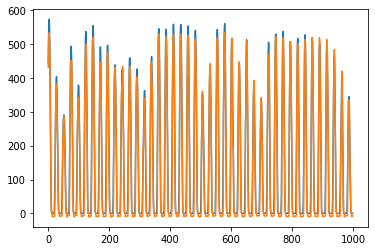

In [ ]:
plt.plot(invyTest[:1000])
plt.plot(invyPred[:1000])

# Wind energy output forecasting


In [ ]:
#Selecting the feature variables and target variables for a Multivariate LSTM
dataPredWindOutput = dataRequired[['AT_wind_onshore_generation_actual', 'AT_windspeed_10m', 'AT_temperature', 'AT_radiation_direct_horizontal', 'AT_radiation_diffuse_horizontal']]
dataPredWindOutput['pred'] = dataPredWindOutput['AT_wind_onshore_generation_actual'].shift(-1)
dataPredWindOutput = dataPredWindOutput.dropna()
dataPredWindOutput.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AT_wind_onshore_generation_actual,AT_windspeed_10m,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,pred
0,109.0,3.27,-4.179,1.5614,25.9639,146.0
1,146.0,3.23,-2.807,7.5467,75.0443,146.0
2,146.0,3.22,-1.315,17.2073,116.9171,158.0
3,158.0,3.22,-0.051,35.4289,146.8923,187.0
4,187.0,3.00,0.791,58.5238,151.4721,244.0


In [ ]:
scalerTwo = MinMaxScaler(feature_range=(0,1))
windScaled = scalerTwo.fit_transform(dataPredWindOutput.values)
windScaled = pd.DataFrame(windScaled)
windScaled.head()

,0,1,2,3,4,5
0,0.042762,0.285083,0.178747,0.001814,0.064377,0.057277
1,0.057277,0.280663,0.209402,0.008767,0.186070,0.057277
2,0.057277,0.279558,0.242738,0.019991,0.289892,0.061985
3,0.061985,0.279558,0.270980,0.041160,0.364214,0.073362
4,0.073362,0.255249,0.289794,0.067990,0.375570,0.095724


In [ ]:
arrDfWind = seriesToSupervised(windScaled, 3, 0)
arrDfWind.fillna(0, inplace = True)
arrDfWind.head()

,0,1,2,3,4,5,0
id,,,,,,,
1,0.042762,0.285083,0.178747,0.001814,0.064377,0.057277,0.061985
2,0.057277,0.280663,0.209402,0.008767,0.186070,0.057277,0.073362
3,0.057277,0.279558,0.242738,0.019991,0.289892,0.061985,0.095724
4,0.061985,0.279558,0.270980,0.041160,0.364214,0.073362,0.117301
5,0.073362,0.255249,0.289794,0.067990,0.375570,0.095724,0.128286


In [ ]:
values = arrDfWind.values
trainSample = int(len(dataPredWindOutput)*0.8)
train = values[: trainSample, :]
test = values[trainSample:, :]
XTrain, yTrain = train[:, :-1], train[:, -1]
XTest, yTest = test[:,:-1], test[:, -1]
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 6), (13989,), (3495, 6), (3495,))

In [ ]:
XTrain = XTrain.reshape((XTrain.shape[0], 1, XTrain.shape[1]))
XTest = XTest.reshape((XTest.shape[0], 1, XTest.shape[1]))
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 1, 6), (13989,), (3495, 1, 6), (3495,))

In [ ]:
modelOne = Sequential()
modelOne.add(LSTM(128, return_sequences = True, input_shape = (XTrain.shape[1], XTrain.shape[2])))
modelOne.add(LSTM(units = 64, return_sequences=True))
modelOne.add(LSTM(units = 32))
modelOne.add(Dense(units = 1))
modelOne.compile(loss = 'mae', optimizer = 'adam')
modelOne.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 128)            69120     
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = modelOne.fit(XTrain, yTrain, epochs= 50, batch_size=32, validation_split = 0.2, shuffle = False)

Train on 11191 samples, validate on 2798 samples
Epoch 1/50
11191/11191 [==============================] - 3s 299us/step - loss: 0.0876 - val_loss: 0.0608
Epoch 2/50
11191/11191 [==============================] - 2s 188us/step - loss: 0.0586 - val_loss: 0.0557
Epoch 3/50
11191/11191 [==============================] - 2s 184us/step - loss: 0.0555 - val_loss: 0.0529
Epoch 4/50
11191/11191 [==============================] - 2s 183us/step - loss: 0.0533 - val_loss: 0.0515
Epoch 5/50
11191/11191 [==============================] - 2s 187us/step - loss: 0.0519 - val_loss: 0.0512
Epoch 6/50
11191/11191 [==============================] - 2s 188us/step - loss: 0.0510 - val_loss: 0.0539
Epoch 7/50
11191/11191 [==============================] - 2s 187us/step - loss: 0.0504 - val_loss: 0.0553
Epoch 8/50
11191/11191 [==============================] - 2s 190us/step - loss: 0.0501 - val_loss: 0.0552
Epoch 9/50
11191/11191 [==============================] - 2s 184us/step - loss: 0.0498 - val_loss: 0.05

In [ ]:
#Making predictions
yPred = modelOne.predict(XTest)
XTest = XTest.reshape((XTest.shape[0],XTest.shape[2]))
invyPred = np.concatenate((yPred, XTest[:, 1:]), axis = 1)
invyPred = scalerTwo.inverse_transform(invyPred)
invyPred = invyPred[:, 0]

yTest = yTest.reshape((len(yTest), 1))
invyTest = np.concatenate((yTest, XTest[:, 1:]), axis = 1)
invyTest = scalerTwo.inverse_transform(invyTest)
invyTest = invyTest[:, 0]

print(f'Mean absolute error {mean_absolute_error(invyTest, invyPred)}')
print(f'Mean squared error {mean_squared_error(invyTest, invyPred)}')
print(f'R2_Score {r2_score(invyTest, invyPred)}')

Mean absolute error 107.15763367960211
Mean squared error 28197.646247335262
R2_Score 0.9293269011163046


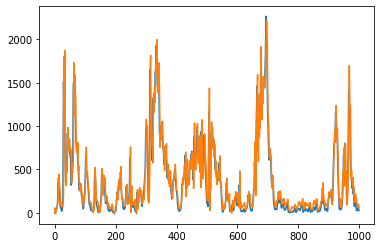

In [ ]:
plt.plot(invyTest[:1000])
plt.plot(invyPred[:1000])

# Demand forecasting model



In [ ]:
#Selecting the feature variables and target variables for a Multivariate LSTM
dataPredDemand = dataRequired[['AT_load_actual_entsoe_power_statistics', 'AT_windspeed_10m', 'AT_temperature', 'AT_radiation_direct_horizontal', 'AT_radiation_diffuse_horizontal']]
dataPredDemand['pred'] = dataPredDemand['AT_load_actual_entsoe_power_statistics'].shift(-1)
dataPredDemand = dataPredDemand.dropna()
dataPredDemand.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AT_load_actual_entsoe_power_statistics,AT_windspeed_10m,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,pred
0,7035.0,3.27,-4.179,1.5614,25.9639,7394.0
1,7394.0,3.23,-2.807,7.5467,75.0443,7770.0
2,7770.0,3.22,-1.315,17.2073,116.9171,7820.0
3,7820.0,3.22,-0.051,35.4289,146.8923,7694.0
4,7694.0,3.00,0.791,58.5238,151.4721,7565.0


In [ ]:
scalerThree = MinMaxScaler(feature_range=(0,1))
demandScaled = scalerThree.fit_transform(dataPredDemand.values)
demandScaled = pd.DataFrame(windScaled)
demandScaled.head()

,0,1,2,3,4,5
0,0.042762,0.285083,0.178747,0.001814,0.064377,0.057277
1,0.057277,0.280663,0.209402,0.008767,0.186070,0.057277
2,0.057277,0.279558,0.242738,0.019991,0.289892,0.061985
3,0.061985,0.279558,0.270980,0.041160,0.364214,0.073362
4,0.073362,0.255249,0.289794,0.067990,0.375570,0.095724


In [ ]:
arrDfDemand = seriesToSupervised(demandScaled, 3, 0)
arrDfDemand.fillna(0, inplace = True)
arrDfDemand.head()

,0,1,2,3,4,5,0
id,,,,,,,
1,0.042762,0.285083,0.178747,0.001814,0.064377,0.057277,0.061985
2,0.057277,0.280663,0.209402,0.008767,0.186070,0.057277,0.073362
3,0.057277,0.279558,0.242738,0.019991,0.289892,0.061985,0.095724
4,0.061985,0.279558,0.270980,0.041160,0.364214,0.073362,0.117301
5,0.073362,0.255249,0.289794,0.067990,0.375570,0.095724,0.128286


In [ ]:
values = arrDfDemand.values
trainSample = int(len(dataPredDemand)*0.8)
train = values[: trainSample, :]
test = values[trainSample:, :]
XTrain, yTrain = train[:, :-1], train[:, -1]
XTest, yTest = test[:,:-1], test[:, -1]
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 6), (13989,), (3495, 6), (3495,))

In [ ]:
XTrain = XTrain.reshape((XTrain.shape[0], 1, XTrain.shape[1]))
XTest = XTest.reshape((XTest.shape[0], 1, XTest.shape[1]))
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 1, 6), (13989,), (3495, 1, 6), (3495,))

In [ ]:
modelTwo = Sequential()
modelTwo.add(LSTM(75, return_sequences = True, input_shape = (XTrain.shape[1], XTrain.shape[2])))
modelTwo.add(LSTM(units = 50, return_sequences=True))
modelTwo.add(LSTM(units = 30))
modelTwo.add(Dense(units = 1))
modelTwo.compile(loss = 'mae', optimizer = 'adam')
modelTwo.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 75)             24600     
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 50)             25200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 59,551
Trainable params: 59,551
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = modelTwo.fit(XTrain, yTrain, epochs= 50, batch_size=32, validation_split = 0.2, shuffle = False)

Train on 11191 samples, validate on 2798 samples
Epoch 1/50
11191/11191 [==============================] - 3s 261us/step - loss: 0.0915 - val_loss: 0.0619
Epoch 2/50
11191/11191 [==============================] - 2s 144us/step - loss: 0.0595 - val_loss: 0.0578
Epoch 3/50
11191/11191 [==============================] - 2s 154us/step - loss: 0.0567 - val_loss: 0.0550
Epoch 4/50
11191/11191 [==============================] - 2s 148us/step - loss: 0.0545 - val_loss: 0.0536
Epoch 5/50
11191/11191 [==============================] - 2s 150us/step - loss: 0.0528 - val_loss: 0.0518
Epoch 6/50
11191/11191 [==============================] - 2s 150us/step - loss: 0.0509 - val_loss: 0.0513
Epoch 7/50
11191/11191 [==============================] - 2s 150us/step - loss: 0.0505 - val_loss: 0.0539
Epoch 8/50
11191/11191 [==============================] - 2s 152us/step - loss: 0.0499 - val_loss: 0.0527
Epoch 9/50
11191/11191 [==============================] - 2s 151us/step - loss: 0.0497 - val_loss: 0.05

In [ ]:
#Making predictions
yPred = modelTwo.predict(XTest)
XTest = XTest.reshape((XTest.shape[0],XTest.shape[2]))
invyPred = np.concatenate((yPred, XTest[:, 1:]), axis = 1)
invyPred = scalerThree.inverse_transform(invyPred)
invyPred = invyPred[:, 0]

yTest = yTest.reshape((len(yTest), 1))
invyTest = np.concatenate((yTest, XTest[:, 1:]), axis = 1)
invyTest = scalerThree.inverse_transform(invyTest)
invyTest = invyTest[:, 0]

print(f'Mean absolute error {mean_absolute_error(invyTest, invyPred)}')
print(f'Mean squared error {mean_squared_error(invyTest, invyPred)}')
print(f'R2_Score {r2_score(invyTest, invyPred)}')

Mean absolute error 296.0471314543749
Mean squared error 214831.2987966421
R2_Score 0.9298904594940975


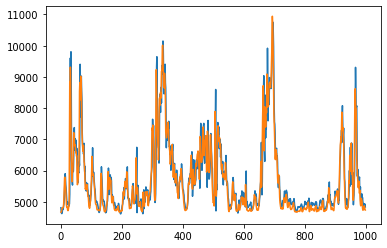

In [ ]:
plt.plot(invyPred[:1000])
plt.plot(invyTest[:1000])

# Uploading the model parameters to drive



In [151]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/My Drive/SolarEnergyGenerationForecasting.h5')

In [ ]:
modelOne.save('/content/drive/My Drive/WinEnergyGenerationForecasting.h5')

In [ ]:
modelTwo.save('/content/drive/My Drive/DemandForecasting.h5')

# The simulation cum forecasting model


In [ ]:
#Having the data in hand and in the right format

In [ ]:
#Demand model input
values = arrDfDemand.values
trainSample = int(len(dataPredDemand)*0.8)
testDemand = values[trainSample:, :]
XTestDemand, yTestDemand = testDemand[:,:-1], testDemand[:, -1]
XTestDemand = XTestDemand.reshape((XTestDemand.shape[0], 1, XTestDemand.shape[1]))
XTestDemand.shape, yTestDemand.shape

((3495, 1, 6), (3495,))

In [ ]:
# #The test demand shall be split into 24 hour intervals
# yPredDemand = modelTwo.predict(XTestDemand)
# XTestDemand = XTestDemand.reshape((XTestDemand.shape[0],XTestDemand.shape[2]))
# invyPredDemand = np.concatenate((yPredDemand, XTestDemand[:, 1:]), axis = 1)
# invyPredDemand = scalerThree.inverse_transform(invyPredDemand)
# invyPredDemand = invyPredDemand[:, 0]

# yTestDemand = yTestDemand.reshape((len(yTestDemand), 1))
# invyTestDemand = np.concatenate((yTestDemand, XTestDemand[:, 1:]), axis = 1)
# invyTestDemand = scalerThree.inverse_transform(invyTestDemand)
# invyTestDemand = invyTestDemand[:, 0]

In [ ]:
#Wind Energy supply
values = arrDfWind.values
trainSample = int(len(dataPredWindOutput)*0.8)
testWind = values[trainSample:, :]
XTestWind, yTestWind = testWind[:,:-1], testWind[:, -1]
XTestWind = XTestWind.reshape((XTestWind.shape[0], 1, XTestWind.shape[1]))
XTestWind.shape, yTestWind.shape

((3495, 1, 6), (3495,))

In [ ]:
# #The test wind shall be split into 24 hours
# yPredWind = modelOne.predict(XTestWind)
# XTestWind = XTestWind.reshape((XTestWind.shape[0],XTestWind.shape[2]))
# invyPredWind = np.concatenate((yPredWind, XTestWind[:, 1:]), axis = 1)
# invyPredWind = scalerTwo.inverse_transform(invyPredWind)
# invyPredWind = invyPredWind[:, 0]

# yTestWind = yTestWind.reshape((len(yTestWind), 1))
# invyTestWind = np.concatenate((yTestWind, XTestWind[:, 1:]), axis = 1)
# invyTestWind = scalerTwo.inverse_transform(invyTestWind)
# invyTestWind = invyTestWind[:, 0]

In [ ]:
#Solar Energy supply
values = arrDfSolar.values
trainSample = int(len(dataPredSolarOutput)*0.8)
testSolar = values[trainSample:, :]
XTestSolar, yTestSolar = testSolar[:,:-1], testSolar[:, -1]
XTestSolar = XTestSolar.reshape((XTestSolar.shape[0], 1, XTestSolar.shape[1]))
XTestSolar.shape, yTestSolar.shape

((3495, 1, 6), (3495,))

In [ ]:
# #The test solar shall be split into 24 hour intervals
# yPredSolar = model.predict(XTestSolar)
# XTestSolar = XTestSolar.reshape((XTestSolar.shape[0],XTestSolar.shape[2]))
# invyPredSolar = np.concatenate((yPredSolar, XTestSolar[:, 1:]), axis = 1)
# invyPredSolar = scalerOne.inverse_transform(invyPredSolar)
# invyPredSolar = invyPredSolar[:, 0]

# yTestSolar = yTestSolar.reshape((len(yTestSolar), 1))
# invyTestSolar = np.concatenate((yTestSolar, XTestSolar[:, 1:]), axis = 1)
# invyTestSolar = scalerOne.inverse_transform(invyTestSolar)
# invyTestSolar = invyTestSolar[:, 0]

In [ ]:
XTestSolar.shape, XTestDemand.shape, XTestWind.shape

((3495, 1, 6), (3495, 1, 6), (3495, 1, 6))

In [ ]:
def weightMatrix():
  array = []
  for i in range(99):
    array.append(1/(10+5*i))
  array.append(1-sum(array))
  return array

In [163]:
weighs = weightMatrix()
weighs

[0.1,
 0.06666666666666667,
 0.05,
 0.04,
 0.03333333333333333,
 0.02857142857142857,
 0.025,
 0.022222222222222223,
 0.02,
 0.01818181818181818,
 0.016666666666666666,
 0.015384615384615385,
 0.014285714285714285,
 0.013333333333333334,
 0.0125,
 0.011764705882352941,
 0.011111111111111112,
 0.010526315789473684,
 0.01,
 0.009523809523809525,
 0.00909090909090909,
 0.008695652173913044,
 0.008333333333333333,
 0.008,
 0.007692307692307693,
 0.007407407407407408,
 0.007142857142857143,
 0.006896551724137931,
 0.006666666666666667,
 0.0064516129032258064,
 0.00625,
 0.006060606060606061,
 0.0058823529411764705,
 0.005714285714285714,
 0.005555555555555556,
 0.005405405405405406,
 0.005263157894736842,
 0.005128205128205128,
 0.005,
 0.004878048780487805,
 0.004761904761904762,
 0.004651162790697674,
 0.004545454545454545,
 0.0044444444444444444,
 0.004347826086956522,
 0.00425531914893617,
 0.004166666666666667,
 0.004081632653061225,
 0.004,
 0.00392156862745098,
 0.0038461538461538464

In [164]:
# 124 twenty four hour long data can be generated
#The running simulation in tandem with forecasting models
batteryLevel = 5000*np.ones((100, 24))
BatteryCapacity = 10000*np.ones((100,24))
for i in range(124):
  XTestSolarHour = XTestSolar[24*i:24*(i+1)]
  XTestWindHour = XTestWind[24*i:24*(i+1)]
  XTestDemandHour = XTestDemand[24*i:24*(i+1)]
  yTestSolarHour = yTestSolar[24*i: 24*(i+1)]
  yTestWindHour = yTestWind[24*i: 24*(i+1)]
  yTestDemandHour = yTestDemand[24*i: 24*(i+1)]

  #Calling the predictor generator scheduler, #Ruchir, we need to display and plot these values, for each 24 hour interval
  arrayinvyPredDemandInelastic, arrayRenewableEnergyOutput, arrayElasticDemandSum, arrayinvyPredDemandElastic, arrayinvyTestDemandInelastic, arrayRenewableEnergyOutputAct, arrayElasticDemandSumAct, arrayinvyTestDemandElastic, whatWeFindOutWeNeeded, whatWeTakeFromGrid, shitLetsTakeItFromBatteryOrDumpItThere = dataGenerator(XTestSolarHour, XTestWindHour, XTestDemandHour, weighs, yTestSolarHour, yTestWindHour, yTestDemandHour)

  #battery updation
  batteryLevel = batteryLevel + shitLetsTakeItFromBatteryOrDumpItThere

  if((batteryLevel>=BatteryCapacity).any()):
    print('Outage!!!')
  

In [ ]:
#To be called at every 24 hour distribution, generates the demand supply distribution
def dataGenerator(XTestSolarHour, XTestWindHour, XTestDemandHour, weighs, yTestSolarHour, yTestWindHour, yTestDemandHour):
  #Solar Energy generation
  yPredSolar = model.predict(XTestSolarHour)
  XTestSolarHour = XTestSolarHour.reshape((XTestSolarHour.shape[0],XTestSolarHour.shape[2]))
  invyPredSolar = np.concatenate((yPredSolar, XTestSolarHour[:, 1:]), axis = 1)
  invyPredSolar = scalerOne.inverse_transform(invyPredSolar)
  invyPredSolar = invyPredSolar[:, 0]

  yTestSolarHour = yTestSolarHour.reshape((len(yTestSolarHour), 1))
  invyTestSolarHour = np.concatenate((yTestSolarHour, XTestSolarHour[:, 1:]), axis = 1)
  invyTestSolarHour = scalerOne.inverse_transform(invyTestSolarHour)
  invyTestSolarHour = invyTestSolarHour[:, 0]

  #Wind Energy Generation
  yPredWind = modelOne.predict(XTestWindHour)
  XTestWindHour = XTestWindHour.reshape((XTestWindHour.shape[0],XTestWindHour.shape[2]))
  invyPredWind = np.concatenate((yPredWind, XTestWindHour[:, 1:]), axis = 1)
  invyPredWind = scalerTwo.inverse_transform(invyPredWind)
  invyPredWind = invyPredWind[:, 0]

  yTestWindHour = yTestWindHour.reshape((len(yTestWindHour), 1))
  invyTestWindHour = np.concatenate((yTestWindHour, XTestWindHour[:, 1:]), axis = 1)
  invyTestWindHour = scalerTwo.inverse_transform(invyTestWindHour)
  invyTestWindHour = invyTestWindHour[:, 0]

  #Demand
  yPredDemand = modelTwo.predict(XTestDemandHour)
  XTestDemandHour = XTestDemandHour.reshape((XTestDemandHour.shape[0],XTestDemandHour.shape[2]))
  invyPredDemand = np.concatenate((yPredDemand, XTestDemandHour[:, 1:]), axis = 1)
  invyPredDemand = scalerThree.inverse_transform(invyPredDemand)
  invyPredDemand = invyPredDemand[:, 0]

  yTestDemandHour = yTestDemandHour.reshape((len(yTestDemandHour), 1))
  invyTestDemandHour = np.concatenate((yTestDemandHour, XTestDemandHour[:, 1:]), axis = 1)
  invyTestDemandHour = scalerThree.inverse_transform(invyTestDemandHour)
  invyTestDemandHour = invyTestDemandHour[:, 0]

  #Elastic and Inelastic demand forecast
  invyPredDemandInElastic = 0.7*invyPredDemand
  invyPredDemandElastic = 0.3*invyPredDemand
  elasticDemandSum = np.sum(invyPredDemandElastic)


  #Elastic and Inelastic demand actual
  invyTestDemandInElastic = 0.7*invyTestDemandHour
  invyTestDemandElastic = 0.3*invyTestDemandHour
  elasticDemandSumAct = np.sum(invyTestDemandElastic)

  #Renewable energy output forecast
  renewableEnergyOutput = invyPredSolar + invyPredWind

  #Renewable energy output actual
  renewableEnergyOutputActual = invyTestSolarHour + invyTestWindHour

  #Splitting the above into different prosumers according to a schema, of course in real life, with more computational power
  #One can train separately for each prosumer
  arrayinvyPredDemandInelastic = np.outer(np.array(weighs), np.array(invyPredDemandInElastic))
  arrayRenewableEnergyOutput = np.outer(np.array(weighs), np.array(renewableEnergyOutput))
  arrayElasticDemandSum = np.array(weighs)*elasticDemandSum    #24 hours
  arrayinvyPredDemandElastic = np.outer(np.array(weighs), np.array(invyPredDemandElastic))

  arrayinvyTestDemandInelastic = np.outer(np.array(weighs), np.array(invyTestDemandInElastic))
  arrayRenewableEnergyOutputAct = np.outer(np.array(weighs), np.array(renewableEnergyOutputActual))
  arrayElasticDemandSumAct = np.array(weighs)*elasticDemandSumAct   #24 hours
  arrayinvyTestDemandElastic = np.outer(np.array(weighs), np.array(invyTestDemandElastic))

  #Calculating the excess offset and meeting it with conventional source, we can only supply what we have forecasted beforehand,
  #not the actual values, we calculate what the each prosumer can take from the grid
  whatWeTakeFromGrid = arrayinvyPredDemandElastic+arrayinvyPredDemandInelastic-arrayRenewableEnergyOutput
  whatWeFindOutWeNeeded = arrayinvyTestDemandElastic+arrayinvyTestDemandInelastic-arrayRenewableEnergyOutputAct

  # The auxiliary battery for managing the errors in prediction of the system, present at each of the nodes
  shitLetsTakeItFromBatteryOrDumpItThere = whatWeTakeFromGrid-whatWeFindOutWeNeeded

  



  #returns

  return arrayinvyPredDemandInelastic, arrayRenewableEnergyOutput, arrayElasticDemandSum, arrayinvyPredDemandElastic, arrayinvyTestDemandInelastic, arrayRenewableEnergyOutputAct, arrayElasticDemandSumAct, arrayinvyTestDemandElastic, whatWeFindOutWeNeeded, whatWeTakeFromGrid, shitLetsTakeItFromBatteryOrDumpItThere


(array([[409.58567845, 417.17279235, 451.43269442, ..., 435.54279584,
         456.41764708, 471.20278304],
        [273.05711897, 278.1151949 , 300.95512961, ..., 290.36186389,
         304.27843139, 314.1351887 ],
        [204.79283923, 208.58639618, 225.71634721, ..., 217.77139792,
         228.20882354, 235.60139152],
        ...,
        [  8.27445815,   8.42773318,   9.11985241, ...,   8.79884436,
           9.22055853,   9.51924814],
        [  8.19171357,   8.34345585,   9.02865389, ...,   8.71085592,
           9.12835294,   9.42405566],
        [665.67706153, 678.00798019, 733.68871352, ..., 707.86373586,
         741.79048273, 765.8199505 ]]),
 array([[ 47.36691173,  62.95521078,  92.32292082, ...,  55.93808353,
          66.84215808,  74.56118586],
        [ 31.57794115,  41.97014052,  61.54861388, ...,  37.29205568,
          44.56143872,  49.70745724],
        [ 23.68345586,  31.47760539,  46.16146041, ...,  27.96904176,
          33.42107904,  37.28059293],
        ...,


In [ ]:
P.shape, W.shape, E.shape, e.shape

((100, 24), (100, 24), (100,), (100, 24))

In [ ]:
np.max(E)

8832.464993905845

# The scheduling algorithm


In [ ]:
EMod = np.hstack([E]*24).reshape((100,24))
EMod.shape

(100, 24)

In [ ]:
eMinValues = np.zeros((100, 24))
eMaxValues = EMod/12

In [ ]:
#The Scheduling function
from cvxpy import *
# def schedulingFunction(PValues, WValues, EValues, eMaxValues, eMinValues):
  e = Variable((100, 24))
  P = Parameter((100, 24))
  W = Parameter((100, 24))
  P.value = PValues
  W.value = WValues
  d = P+e-W
  dSum = sum(d, axis = 0)
  ramp = diff(dSum)

  cost = norm(ramp, 'inf')
  obj = Minimize(cost)
  constraints = [eMinValues <= e, e<= eMaxValues, sum(e) == EValues]
  prob = Problem(obj, constraints)
  optValue = prob.solve()
  solutionElasticDemand = e.value
  return np.array(solutionElasticDemand)

IndentationError: ignored

In [ ]:
result = schedulingFunction(P, W, E, 2*eMaxValues, eMinValues)

In [ ]:
print(result)

None


In [ ]:
#The generating function for actual values


In [155]:
pd.DataFrame(arrayinvyPredDemandElastic).to_csv('sendToRuchirShitMyMemorySucks.csv')


In [159]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [161]:
!cp sendToRuchirShitMyMemorySucks.csv '/drive/My Drive'

cp: failed to access '/drive/My Drive': Transport endpoint is not connected
